# Earthquake Prediction Project 

>Question: Build a full data pipleine which uses Machine Learning to predicts the Magnitude and Coordinates of the next earthquake.
​

Within this project I have created a local Data Engineering infrastructure using:
* Jupyter Lab - For scheduling daily jobs to retreive up to date Earthquake API results
* MySQL - To store the historical earthquake dataset and predicted earthquake information
* Power BI - To visualise additional trends and patterns of earthquakes.

Within this Jupyter notebook, I have gone through the Data Science pipeline and also implemented a Machine learning model. <br> Within this notebook, for the prediction of an earthquake, I have used:
- A Standard scaler to scale the features to unit variance.
- A Multivarient Linear Regression model with depth and time as the features.
- Simple evaluation techniquestion which will be useful for hyperparameter tuning.

Additional fine-tuning will be added to this project models<br>
​
**Data Dictionary**
- id : **Categorical**
- magnitude : **Quantitive**
- time : epoch format - **Quantitive**
- longitude : **Quantitive**
- latitude :  **Quantitive**
- depth :  **Quantitive**

​
I have added comments explaining the steps undertaken throughout this notebook.

# Extracting

### Data Cleaning

In [145]:
import requests
import json
import pandas as pd
import numpy as np

In [146]:
# We use this function to get the dataset
#FYI, the amount of earthquake with a magnitude of 5 or greater is large,
# We only get the earthquakes since 23 August 2022.
#Additionally the dataset is large and can take sometime for the request to return
def fetch_earthqk_data(start_time, end_time):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2000-01-01&endtime=now&limit=1000&orderby=time&minmagnitude=5"
    response = requests.get(url)
    data = json.loads(response.text)
    return data


In [147]:
# We define the start date as well as getting the latest earthquakes by specifiying the now value and call the get request function
start_time = "2000-01-01"
end_time = "now"
try:
    data = fetch_earthqk_data(start_time, end_time)
except Exception as e:
        print(f"Error fetching data from USGS' API: {e}")
        raise

In [148]:
# From testing the response.json from Postman, we'll need the unique ID, magnitude, datetime, longitude, latititude and depth. 
# The below features will be usful for our machine model. Try catches have been used as numerous formatting errors were caused from testing
try:
    earthquakes = []
    for feature in data['features']:
        id = feature["id"]
        magnitude = feature['properties']['mag']
        time = feature['properties']['time']
        longitude, latitude, depth = feature['geometry']['coordinates']
        earthquakes.append([id, magnitude, time, longitude, latitude, depth])
except Exception as e:
    print(f"Error with formatting the response data: {e}")
    raise

In [149]:
df = pd.DataFrame(earthquakes, columns=['id', 'magnitude', 'time', 'longitude', 'latitude', 'depth'])
df.head()

,id,magnitude,time,longitude,latitude,depth
0,us7000jlkc,5.2,1679363121616,121.3874,23.5176,11.587
1,us7000jlkb,5.5,1679363053675,-84.0943,9.3599,35.000
2,us7000jlef,5.1,1679313435766,-27.8543,-56.0832,133.403
3,us7000jlca,5.0,1679267104811,158.2407,63.3986,10.000
4,ak0233l8vwxa,5.4,1679238387280,-151.9070,59.6095,65.400


In [164]:
# Interestingly, you can see the time in Epoch format already formatted for us for modelling.

# Transforming

### Exploratory Data Analysis

In [151]:
df.isnull().sum()

id           0
magnitude    0
time         0
longitude    0
latitude     0
depth        0
dtype: int64

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   time       1000 non-null   int64  
 3   longitude  1000 non-null   float64
 4   latitude   1000 non-null   float64
 5   depth      1000 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


In [153]:
df.describe()

,magnitude,time,longitude,latitude,depth
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,5.325730,1.670528e+12,33.927284,-0.187410,56.446992
std,0.424614,5.159474e+09,117.212605,30.969292,108.828667
min,5.000000,1.661272e+12,-179.966100,-65.407100,3.744000
25%,5.000000,1.666184e+12,-68.910925,-20.145525,10.000000
50%,5.200000,1.670393e+12,70.728600,-3.287050,14.981000
75%,5.425000,1.675380e+12,140.002475,24.924975,48.181000
max,7.800000,1.679363e+12,179.973800,72.518400,660.000000


In [154]:
df.shape

(1000, 6)

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

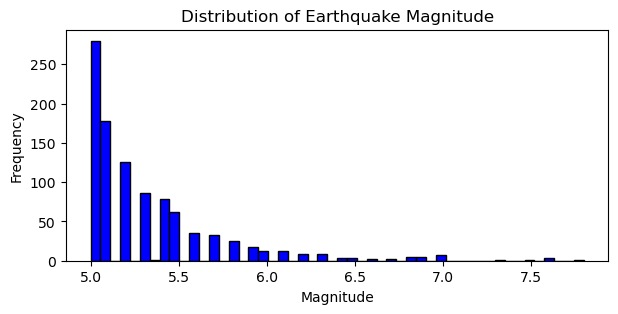

In [159]:
# Distribution of earthquake magnitudes
plt.figure(figsize=(7, 3))
plt.hist(df['magnitude'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Earthquake Magnitude')
plt.show()

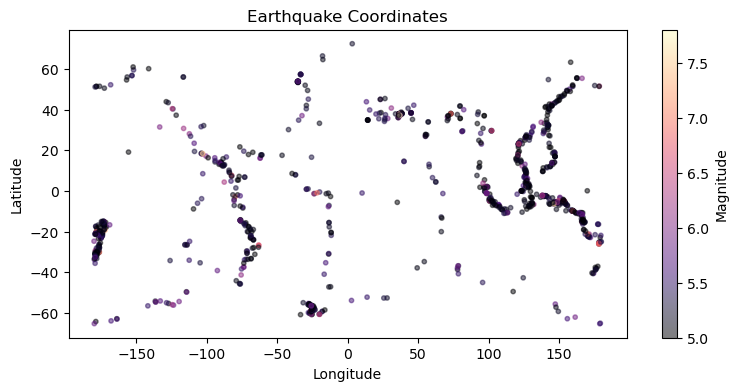

In [160]:
# A very visual visualisation of earthquake locations.
plt.figure(figsize=(9, 4))
plt.scatter(df['longitude'], df['latitude'], s=10, c=df['magnitude'], cmap='magma', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Coordinates')
plt.colorbar(label='Magnitude')
plt.show()

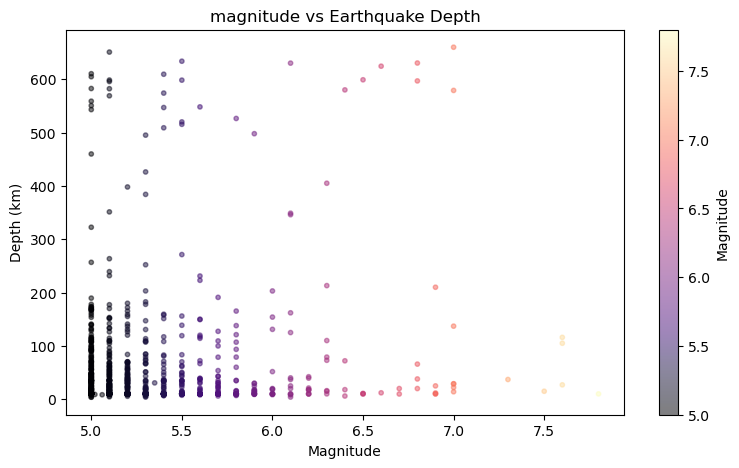

In [165]:
# We can see a weak negative correlation between depth and magnitude visually hear. 
# The higher the magnitude the higher the depth of the earthquake
plt.figure(figsize=(9, 5))
plt.scatter(df['magnitude'], df['depth'], s=10, c=df['magnitude'], cmap='magma', alpha=0.5)
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')
plt.title('magnitude vs Earthquake Depth')
plt.colorbar(label='Magnitude')
plt.show()

### Data Preprocessing

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

In [163]:
df.head()

,id,magnitude,time,longitude,latitude,depth
0,us7000jlkc,5.2,1679363121616,121.3874,23.5176,11.587
1,us7000jlkb,5.5,1679363053675,-84.0943,9.3599,35.000
2,us7000jlef,5.1,1679313435766,-27.8543,-56.0832,133.403
3,us7000jlca,5.0,1679267104811,158.2407,63.3986,10.000
4,ak0233l8vwxa,5.4,1679238387280,-151.9070,59.6095,65.400


In [123]:
# From researching, time and depth are the best features to predict the magnitude and coordinates.
X = df[['time', 'depth']]
y = df[['magnitude', 'latitude', 'longitude']]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [126]:
# Convert epoch timestamp to datatime format
df['time'] = pd.to_datetime(df['time'], unit='ms')

### Data Modelling

In [128]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [129]:
# We undergo our prediction
y_pred = model.predict(X_test_scaled)

In [130]:
# Checking the predicted value
print(y_pred[0])

[ 5.35458904 -0.77442749 42.51058646]


In [131]:
# We evaluate the accuracy of our score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Evaluation

In [132]:
# We can see our evaluation values needs improvements. 
# Especially with our R squared with the relationship of the two variables explains 1% of the variation of the data.
# We can see our Mean Absolute Error is high as well .
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 42.59265485883399
Mean Squared Error: 4851.91503102462
Root Mean Squared Error: 69.6556891504536
R-squared: -0.004192289585219777


In [133]:
# We now predict the magnitude and coordinates of the next earthquake
# If a earthquake happened now with the depth of (), it would have the 'magnitude', 'latitude', 'longitude'

In [134]:
import datetime
import random

In [135]:
# Current date and time
current_time = datetime.datetime.now()

# Generate a random depth value that ranges from 0 and 700
new_depth = round(random.uniform(0, 700), 1)

# Convert the new time to Unix timestamp so it can be scaled
new_time_unix = int(current_time.timestamp())

#We create a dataframe so feature names are not lost when scaling the two features
predicting_data = pd.DataFrame([[new_time_unix, new_depth]], columns=['time', 'depth'])

# We now standardise the new time and depth values using the same scaler used from the training data
new_data_scaled = scaler.transform(predicting_data)

In [136]:
# We now predict for the new time and depth values
new_prediction = model.predict(new_data_scaled)

In [137]:
# We check the magnitude, latitude, and longitude for the next earthquake
print(f"Predicted Magnitude for Next Earthquake: {new_prediction[0][0]}")
print(f"Predicted Latitude for Next Earthquake: {new_prediction[0][1]}")
print(f"Predicted Longitude for Next Earthquake: {new_prediction[0][2]}")

Predicted Magnitude for Next Earthquake: 5.358576326370803
Predicted Latitude for Next Earthquake: -0.7610411849427643
Predicted Longitude for Next Earthquake: 44.333687505133526


##### We will insert insert the predicted earthquake into our database.
##### The next stage is Loading our data onto a MySQL database 

# Loading onto MySQL

In [138]:
import mysql.connector
from sqlalchemy import create_engine

In [139]:
# Connect to MySQL db
try:
    user = 'root'
    password = 'admin'
    host = 'localhost'
    database = 'earthquake'

    connection_string = f"mysql+mysqlconnector://{user}:{password}@{host}/{database}"
    engine = create_engine(connection_string)
except Exception as e:
    print(f"Error establishing connection to MySQL database: {e}")
    raise

In [140]:
# We create a table with the appropriate columns from our earquakes Dataframe in MySQL database
try:
    eq_table = 'earthquakes'

    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {eq_table} (
        id varchar(50) PRIMARY KEY,
        time DATETIME,
        magnitude DOUBLE,
        latitude DOUBLE,
        longitude DOUBLE,
        depth DOUBLE
        
    );
    """

    with engine.connect() as conn:
        conn.execute(create_table_query)
except Exception as e:
    print(f"Error creating table in database: {e}")
    raise

# We first delete the previous dataset before inserting the new list of earthquakes
try:
    delete_query = f"DELETE FROM {eq_table}"
    with engine.connect() as conn:
        conn.execute(delete_query)
        conn.close()
except Exception as e:
    print(f"Error deleting data from earthquakes table: {e}")
    raise

    
# We insert the DataFrame data into earthquakes table
try:
    df.to_sql(eq_table, engine, if_exists='append', index=False)
    conn.close()
except Exception as e:
    print(f"Error inserting data into MySQL table: {e}")
    raise

In [141]:
# We insert the predicted earthquakes into a new table
try:
    predicted_eq = 'predicted_eq'

    create_predicted_table_query = f"""
    CREATE TABLE IF NOT EXISTS {predicted_eq} (
        id INT AUTO_INCREMENT PRIMARY KEY,
        predicted_magnitude DOUBLE,
        predicted_latitude DOUBLE,
        predicted_longitude DOUBLE,
        current_datetime DATETIME,
        random_depth DOUBLE
    );
    """

    with engine.connect() as conn:
        conn.execute(create_predicted_table_query)
        conn.close()
except Exception as e:
    print(f"Error creating table for predicted data in MySQL database: {e}")
    raise
    
# We again delete the previous predcited equakes for now before inserting new data
try:
    delete_query = f"DELETE FROM {predicted_eq}"
    with engine.connect() as conn:
        conn.execute(delete_query)
        conn.close()
except Exception as e:
    print(f"Error deleting data from MySQL table: {e}")
    raise

In [142]:
# Finally, we insert the predicted data into the MySQL table
try:

    insert_predicted_data_query = f"""
    INSERT INTO {predicted_eq} (`predicted_magnitude`, `predicted_latitude`, `predicted_longitude`, `current_datetime`, `random_depth`)
    VALUES ({round(new_prediction[0][0], 2)}, {new_prediction[0][1]}, {new_prediction[0][2]}, '{current_time}', '{new_depth}');
    """

    with engine.connect() as conn:
        conn.execute(insert_predicted_data_query)
        conn.close()
except Exception as e:
    print(f"Error inserting predicted data into MySQL table: {e}")
    raise